In [1]:
import retro
from gym import Env
from gym.spaces import MultiBinary, Box, Discrete
import numpy as np
import cv2
from matplotlib import pyplot as plt    

In [2]:
class StreetFighter(Env):
    def __init__(self,game_state='Champion.Level1.RyuVsGuile.state',record=False):
        super().__init__()
        self.observation_space = Box(low=0,high=255,shape=(84,84,1), dtype=np.uint8)
        self.action_space = Discrete(2**12)
        self.total_matches_won = 0
        self.total_enemy_matches_won = 0
        self.prev_matches_won = 0
        self.prev_enemy_matches_won = 0
        self.record = record
        # if record:
        #     self.game = retro.make(game='StreetFighterII-Champion', record='.',state=game_state,use_restricted_actions=retro.Actions.DISCRETE)
        # else:
        self.game = retro.make(game='StreetFighterII-Champion', state=game_state,use_restricted_actions=retro.Actions.DISCRETE)


    def step(self, action):
        obs, reward, done, info = self.game.step(action)
        obs_orig = obs
        obs = self.preprocess(obs)
        frame_delta = obs - self.previous_frame
        self.previous_frame = obs
        if self.prev_matches_won > info['matches_won']:
            self.prev_matches_won = info['matches_won']
        if self.prev_enemy_matches_won > info['enemy_matches_won']:
            self.prev_enemy_matches_won = info['enemy_matches_won']
        self.total_matches_won = self.total_matches_won + info['matches_won'] - self.prev_matches_won
        self.total_enemy_matches_won = self.total_enemy_matches_won + info['enemy_matches_won'] - self.prev_enemy_matches_won
        self.prev_matches_won = info['matches_won']
        self.prev_enemy_matches_won = info['enemy_matches_won']
        reward = info['score'] - self.score
        self.score = info['score']
        self.obs_orig = obs_orig
        return frame_delta, reward, done, info
        
    def get_obs_orig(self):
        return self.obs_orig

    def render(self,*args,**kwargs):
        self.game.render()

    def reset(self):
        obs = self.game.reset()
        obs = self.preprocess(obs)
        self.previous_frame = obs
        self.score = 0
        self.prev_matches_won = 0
        self.prev_enemy_matches_won = 0
        return obs

    def preprocess(self, observation):
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (84,84), cv2.INTER_CUBIC)
        channels = np.reshape(resize, (84,84,1))
        return channels

    def close(self):
        self.game.close()

In [147]:
env.close()

In [3]:
env = StreetFighter(game_state='Hyper.Level1.RyuVsDhalsim.state')

In [4]:
obs = env.reset()
action = env.action_space.sample()
while True:
    state, reward, done, info = env.step(action)
    # if reward != 0:
    #     print(reward)
    #     print(info)
    env.render()
    if done:
        break
    action = env.action_space.sample()
env.close()

c:\Users\reece\anaconda3\envs\streetfighter37_qrdqn\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


In [3]:
import optuna
import os
from stable_baselines3 import DQN
# from sb3_contrib import QRDQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
LOG_DIR = './logs/DQN/RyuHyper'
OPT_DIR = './opt/DQN/RyuHyper'
CHECKPOINT_DIR = './train/DQN/RyuHyper'

In [7]:
def optimize(trial):
    return {
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-5,1e-4),
        'gamma':trial.suggest_loguniform('gamma', 0.8,0.9999),
        'tau':trial.suggest_loguniform('tau', 0.001,0.01),
    }

In [9]:
env.close()

In [8]:
def optimize_agent(trial):
    try:
        model_params = optimize(trial)
        env = StreetFighter(game_state='Champion.Level1.MBisonVsKen.state')
        env = Monitor(env,LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env,4,channels_order='last')

        model = DQN("CnnPolicy",env,tensorboard_log=LOG_DIR,verbose=0,batch_size=256,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 
        model.learn(total_timesteps=10000)

        mean_reward, _ = evaluate_policy(model,env,n_eval_episodes=10)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        print(mean_reward)
        
        return mean_reward
    except Exception as e:
        print(e)
        return -1000

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent,n_trials=10,n_jobs=1)

[I 2024-04-26 01:39:12,652] A new study created in memory with name: no-name-c3a7d7a0-d597-4169-b825-1a68c3028cec
c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  after removing the cwd from sys.path.
c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This

30000.0


[I 2024-04-26 01:50:55,104] Trial 1 finished with value: 2800.0 and parameters: {'learning_rate': 1.7887245961766925e-05, 'gamma': 0.9036578312345488, 'tau': 0.008457484056831197}. Best is trial 0 with value: 30000.0.


2800.0


[I 2024-04-26 01:54:32,854] Trial 2 finished with value: 600.0 and parameters: {'learning_rate': 8.323482655912327e-05, 'gamma': 0.8965641256809231, 'tau': 0.0014913904861179003}. Best is trial 0 with value: 30000.0.


600.0


[I 2024-04-26 01:57:08,222] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 6.418054239844212e-05, 'gamma': 0.8913201680257214, 'tau': 0.003702351016578276}. Best is trial 0 with value: 30000.0.


0.0


[I 2024-04-26 02:07:17,341] Trial 4 finished with value: 19800.0 and parameters: {'learning_rate': 1.9302743639428782e-05, 'gamma': 0.8842604834816046, 'tau': 0.002585490537379548}. Best is trial 0 with value: 30000.0.


19800.0


[I 2024-04-26 02:14:38,220] Trial 5 finished with value: 13700.0 and parameters: {'learning_rate': 2.9667755008135658e-05, 'gamma': 0.8236520518137667, 'tau': 0.0014328933400145102}. Best is trial 0 with value: 30000.0.


13700.0


[I 2024-04-26 02:19:55,540] Trial 6 finished with value: 1300.0 and parameters: {'learning_rate': 1.6765398902473234e-05, 'gamma': 0.9207857707481593, 'tau': 0.0014409219949906415}. Best is trial 0 with value: 30000.0.


1300.0


[I 2024-04-26 02:24:02,940] Trial 7 finished with value: 4300.0 and parameters: {'learning_rate': 1.4943354561910721e-05, 'gamma': 0.8774758020389098, 'tau': 0.001734610979691799}. Best is trial 0 with value: 30000.0.


4300.0


[I 2024-04-26 02:32:10,411] Trial 8 finished with value: 28400.0 and parameters: {'learning_rate': 2.2839167556398748e-05, 'gamma': 0.8263634392651135, 'tau': 0.005126092224281044}. Best is trial 0 with value: 30000.0.


28400.0


[I 2024-04-26 02:39:57,325] Trial 9 finished with value: 13200.0 and parameters: {'learning_rate': 5.409781672519991e-05, 'gamma': 0.9070773075744816, 'tau': 0.0014010944800243474}. Best is trial 0 with value: 30000.0.


13200.0


In [10]:
study.best_trial

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[30000.0], datetime_start=datetime.datetime(2024, 4, 26, 1, 39, 12, 654753), datetime_complete=datetime.datetime(2024, 4, 26, 1, 45, 54, 859033), params={'learning_rate': 4.257797176934804e-05, 'gamma': 0.9930042618672252, 'tau': 0.0029921081489775623}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-05, step=None), 'gamma': FloatDistribution(high=0.9999, log=True, low=0.8, step=None), 'tau': FloatDistribution(high=0.01, log=True, low=0.001, step=None)}, trial_id=0, value=None)

In [11]:
study.best_params

{'learning_rate': 4.257797176934804e-05,
 'gamma': 0.9930042618672252,
 'tau': 0.0029921081489775623}

In [5]:
from stable_baselines3.common.callbacks import BaseCallback

In [10]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback,self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}_'.format(self.n_calls))
            self.model.save(model_path)
            self.logger.record('matches_won', self.training_env.get_attr('total_matches_won')[0])
            self.logger.record('enemy_matches_won', self.training_env.get_attr('total_enemy_matches_won')[0])

        return True

In [11]:
callback = TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)

In [25]:
env.close()

In [12]:
env = StreetFighter(game_state='Hyper.Level1.RyuVsDhalsim.state')
env = Monitor(env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

In [13]:
model_params = {}
model_params['learning_rate'] = 4.257797176934804e-05
model_params['gamma'] = 0.9930042618672252
model_params['tau'] = 0.0029921081489775623

In [14]:
model = DQN("CnnPolicy",env,tensorboard_log=LOG_DIR,verbose=2,batch_size=256,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 
# model.load(os.path.join(OPT_DIR, 'trial_0_best_model.zip'))
model.load(os.path.join(OPT_DIR, 'trial_2_best_model.zip'))
model.learn(total_timesteps=1000000,callback=callback)
# can increase training time and learning rate later

Using cpu device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/DQN/RyuHyper\DQN_12
----------------------------------
| enemy_matches_won   | 10       |
| matches_won         | 16       |
| rollout/            |          |
|    ep_len_mean      | 1.52e+04 |
|    ep_rew_mean      | 5.54e+04 |
|    exploration_rate | 0.423    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 70       |
|    time_elapsed     | 865      |
|    total_timesteps  | 60703    |
| train/              |          |
|    learning_rate    | 4.26e-05 |
|    loss             | 0.385    |
|    n_updates        | 2675     |
----------------------------------
----------------------------------
| enemy_matches_won   | 19       |
| matches_won         | 21       |
| rollout/            |          |
|    ep_len_mean      | 1.24e+04 |
|    ep_rew_mean      | 4.33e+04 |
|    exploration_rate | 0.0551   |
| time/               |          |
|    episodes         | 8    

In [21]:
env.close()

In [22]:
env = StreetFighter(game_state='Champion.Level1.RyuVsGuile.state')
env = Monitor(env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

In [16]:
model = DQN.load(os.path.join(CHECKPOINT_DIR, 'best_model_1000000_'))
# model = QRDQN.load(os.path.join('./train/QRDQN/', 'best_model_1000000_'))
# Ken best (steps - reward) 1000000 - 1400,  50000 - 3300
# Guile best (steps - reward) 1000000 - 2700, 
# Zangief best (steps - reward) 1000000 - 18400, 58000 - 10300
# Chun-Li best (steps - reward) 1000000 - 23200, 500000 - 16900, 50000 = 11400
# Balrog best (steps - reward) 50000 - 2500, 600000 - 800, 1,000,000 - 0
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=1)
print(mean_reward)

In [6]:
from matplotlib import animation
import matplotlib.pyplot as plt

In [7]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=180)

In [18]:
env.close()

c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\stable_baselines3\common\buffers.py:220: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 4.52GB > 3.73GB
  "This system does not have apparently enough memory to store the complete "
c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
MovieWriter imagemagick unavailable; using Pillow instead.


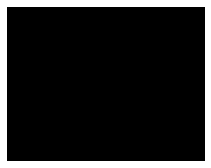

In [8]:
"""
Ensure you have imagemagick installed with 
sudo apt-get install imagemagick
Open file in CLI with:
xgd-open <filelname>
"""

#Make gym env
my_env = StreetFighter(game_state='Hyper.Level1.RyuVsDhalsim.state')
env = Monitor(my_env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

model = DQN.load(os.path.join(CHECKPOINT_DIR, 'best_model_1000000_'))
obs = env.reset()
done = False
frames = []

while not done:
    if done:
        break
    # frames.append(env.render(mode="rgb_array"))
    env.render()
    obs,reward,done,info = env.step(model.predict(obs)[0])
    rec_obs = my_env.get_obs_orig()
    frames.append(rec_obs)
env.close()

save_frames_as_gif(frames)